episode: 0/50, score: 35, e: 0.99
episode: 1/50, score: 35, e: 0.83
episode: 2/50, score: 35, e: 0.69
episode: 3/50, score: 22, e: 0.62
episode: 4/50, score: 16, e: 0.57
episode: 5/50, score: 24, e: 0.51
episode: 6/50, score: 9, e: 0.49
episode: 7/50, score: 14, e: 0.45
episode: 8/50, score: 15, e: 0.42
episode: 9/50, score: 8, e: 0.4
episode: 10/50, score: 10, e: 0.38
episode: 11/50, score: 9, e: 0.37
episode: 12/50, score: 10, e: 0.35
episode: 13/50, score: 10, e: 0.33
episode: 14/50, score: 8, e: 0.32
episode: 15/50, score: 10, e: 0.3
episode: 16/50, score: 7, e: 0.29
episode: 17/50, score: 16, e: 0.27
episode: 18/50, score: 9, e: 0.26
episode: 19/50, score: 8, e: 0.25
episode: 20/50, score: 10, e: 0.24
episode: 21/50, score: 9, e: 0.23
episode: 22/50, score: 12, e: 0.21
episode: 23/50, score: 9, e: 0.2
episode: 24/50, score: 9, e: 0.19
episode: 25/50, score: 9, e: 0.19
episode: 26/50, score: 14, e: 0.17
episode: 27/50, score: 8, e: 0.17
episode: 28/50, score: 9, e: 0.16
episode: 29

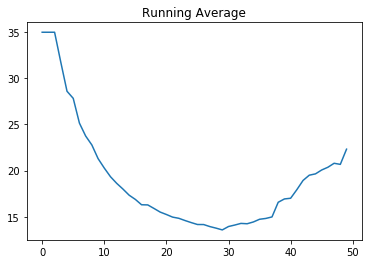

In [9]:
# -*- coding: utf-8 -*-
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

EPISODES = 1000

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)
        
    def plot_running_avg(self, totalrewards):
        N = len(totalrewards)
        running_avg = np.empty(N)
        for t in range(N):
            running_avg[t] = np.mean(totalrewards[max(0, t-100):(t+1)])
        plt.plot(running_avg)
        plt.title("Running Average")
        plt.show()


if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    # agent.load("./save/cartpole-dqn.h5")
    done = False
    batch_size = 32
    episode_reward = []

    for e in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        for time in range(500):
            # env.render()
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -5
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, EPISODES, time, agent.epsilon))
                episode_reward.append(time)
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
    agent.plot_running_avg(episode_reward)
        # if e % 10 == 0:
        #     agent.save("./save/cartpole-dqn.h5")